In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

np.random.seed(42)

Image shape: (1080, 1920, 3)


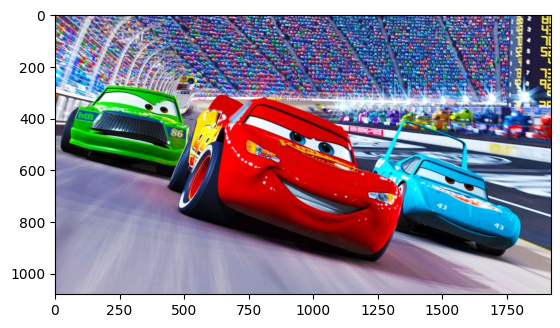

In [2]:
image_bmp = Image.open("tachki.bmp")
image_tensor = np.array(image_bmp).astype(np.uint8)

print(f"Image shape: {image_tensor.shape}")
plt.imshow(image_bmp)
plt.show()

In [4]:
def numpy_method(A, rank):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    return U[:, :rank], S[:rank], Vt[:rank, :]

Реализуем "Block SVD Power Method" из статьи "Image Compression Based on Block SVD
Power Method"

In [5]:
def block_power(A, rank, iters = 20, eps = 0.1):
    U = np.zeros((A.shape[0], rank))
    S = np.zeros(rank)
    V = np.zeros((A.shape[1], rank))

    for _ in range(iters):
        Q, R = np.linalg.qr(A @ V)
        U = Q[:, :rank]

        Q, R = np.linalg.qr(A.T @ U)
        V = Q[:, :rank]
        S = np.diag(R[:rank, :rank])

        if np.linalg.norm(A @ V - U @ R[:rank, :rank]) < eps:
            break 

    return U, S, V.T

In [6]:
def power_method(A, rank):
    U = np.zeros((A.shape[0], rank))
    S = np.zeros(rank)
    Vt = np.zeros((rank, A.shape[1]))

    for i in range(rank):
        x = np.random.normal(0, 1, size=A.shape[1])
        x = A.T @ A @ x

        v = x / np.linalg.norm(x)
        sigma = np.linalg.norm(A @ v)
        u = A @ v / sigma

        U[:, i] = u
        Vt[i, :] = v
        S[i] = sigma
        A = A - sigma * np.outer(u, v)

    return U, S, Vt


In [7]:
def compress(image, method, rank):  
    Rmtr = image[:,:,0]
    Gmtr = image[:,:,1]
    Bmtr = image[:,:,2]

    if method == "numpy":
        Ru, Rs, Rvh = numpy_method(Rmtr, rank)
        Gu, Gs, Gvh = numpy_method(Gmtr, rank)
        Bu, Bs, Bvh = numpy_method(Bmtr, rank)

    elif method == "power_method":
        Ru, Rs, Rvh = power_method(Rmtr, rank)
        Gu, Gs, Gvh = power_method(Gmtr, rank)
        Bu, Bs, Bvh = power_method(Bmtr, rank)

    elif method == "block_power":
        Ru, Rs, Rvh = block_power(Rmtr, rank)
        Gu, Gs, Gvh = block_power(Gmtr, rank)
        Bu, Bs, Bvh = block_power(Bmtr, rank)

    return ((Ru, Rs, Rvh),
            (Gu, Gs, Gvh),
            (Bu, Bs, Bvh))


def decompress(SVD_of_RGB):
    Ru, Rs, Rvh = SVD_of_RGB[0]
    Gu, Gs, Gvh = SVD_of_RGB[1]
    Bu, Bs, Bvh = SVD_of_RGB[2]

    Rs_mtr = np.diag(Rs)
    Gs_mtr = np.diag(Gs)
    Bs_mtr = np.diag(Bs)

    reduced_im = np.zeros((Ru.shape[0], Rvh.shape[1], 3),np.uint8)
    reduced_im[:, :, 0] = Ru @ Rs_mtr @ Rvh
    reduced_im[:, :, 1] = Gu @ Gs_mtr @ Gvh
    reduced_im[:, :, 2] = Bu @ Bs_mtr @ Bvh

    return reduced_im

Для каждого алгоритма посмортим на картинки для разного количество сингулярных значений

In [10]:
ranks = [5, 20, 50, 100, 200, 400]
def show_compressed_images(method):
    plt.figure(figsize=(18,8))
    errors = []
    memories = []
    compression_time = 0

    for i, rank in enumerate(ranks):
        
        start_time = time.time()
        IR = compress(image_tensor, method, rank)
        compression_time = compression_time + time.time() - start_time

        im_res = decompress(IR)

        relative_err = np.linalg.norm(im_res.astype(np.float64) - image_tensor.astype(np.float64)) / \
            np.linalg.norm(image_tensor.astype(np.float64))

        mem = (image_tensor.shape[0] * rank + rank + image_tensor.shape[1] * rank) / \
            (image_tensor.shape[0] * image_tensor.shape[1])
    
        errors.append(relative_err)
        memories.append(mem)

        plt.subplot(2,3,i+1)
        plt.imshow(Image.fromarray(im_res,"RGB"))
        plt.xticks(())
        plt.yticks(())
        plt.title(f"rank = {rank}")

    return errors, memories, compression_time

compression_time = 25.4738712310791


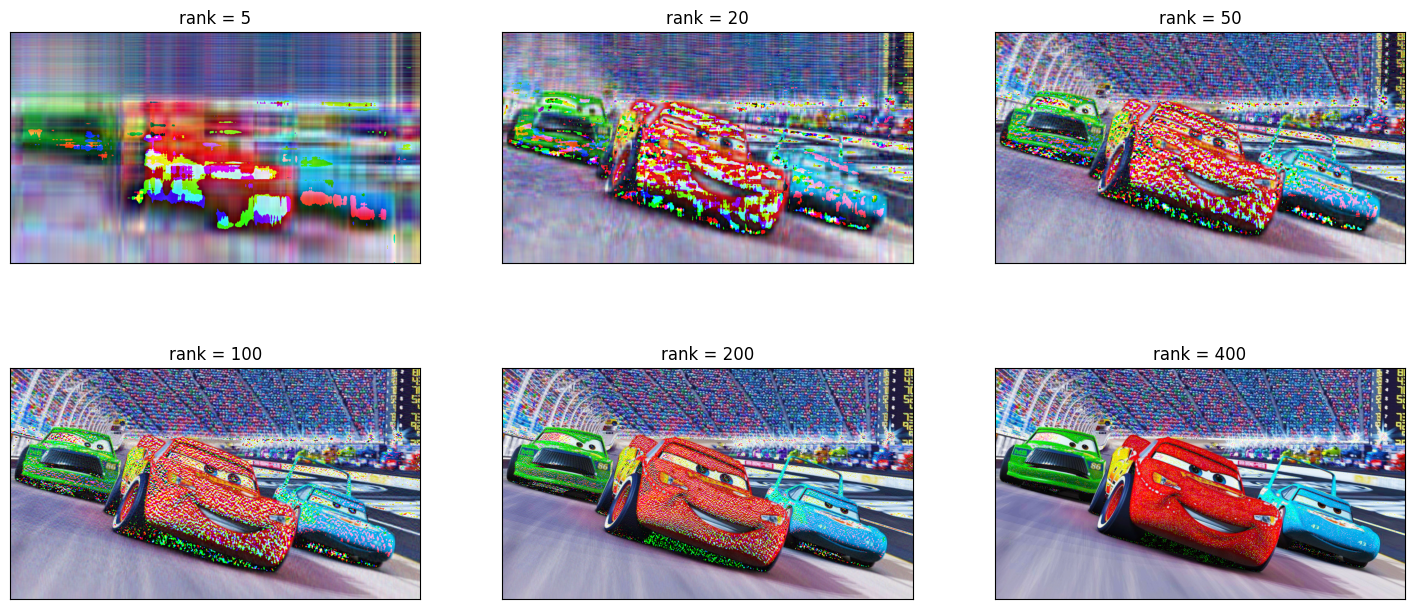

In [11]:
errors_numpy, mem_numpy, compression_time = show_compressed_images("numpy")
print(f"compression_time = {compression_time}")

compression_time = 239.12060499191284


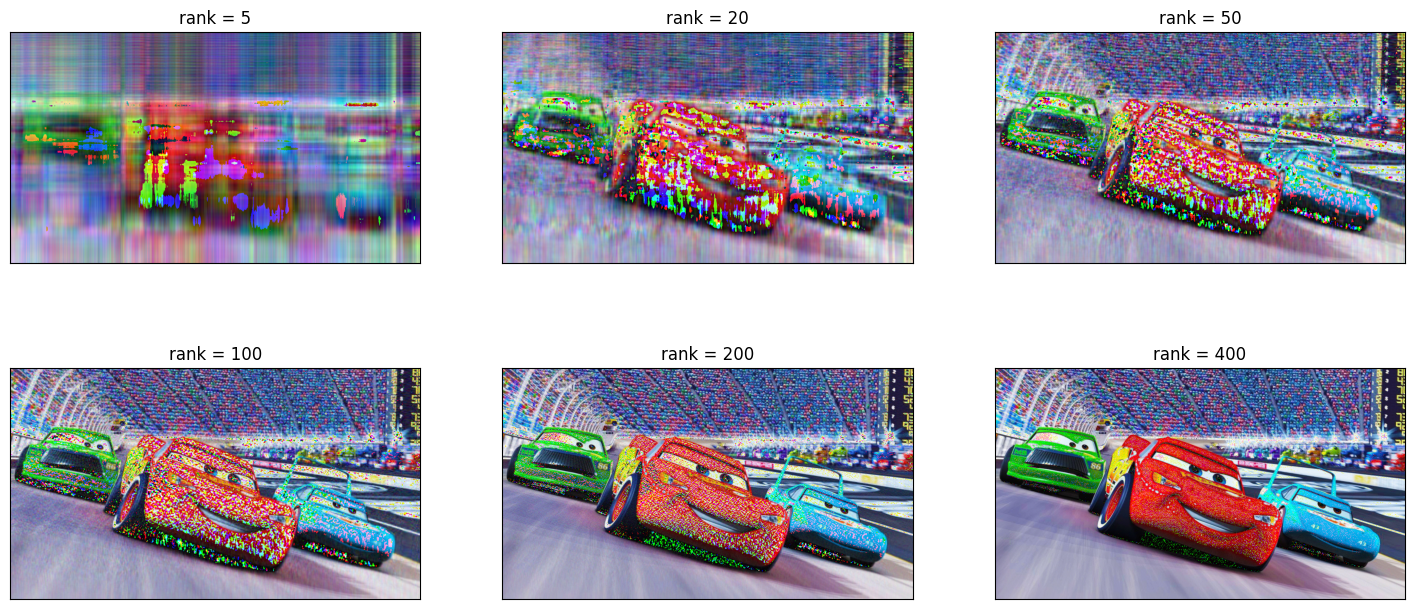

In [12]:
errors_power_method, mem_power_method, compression_time = show_compressed_images("power_method")
print(f"compression_time = {compression_time}")

compression_time = 33.062740087509155


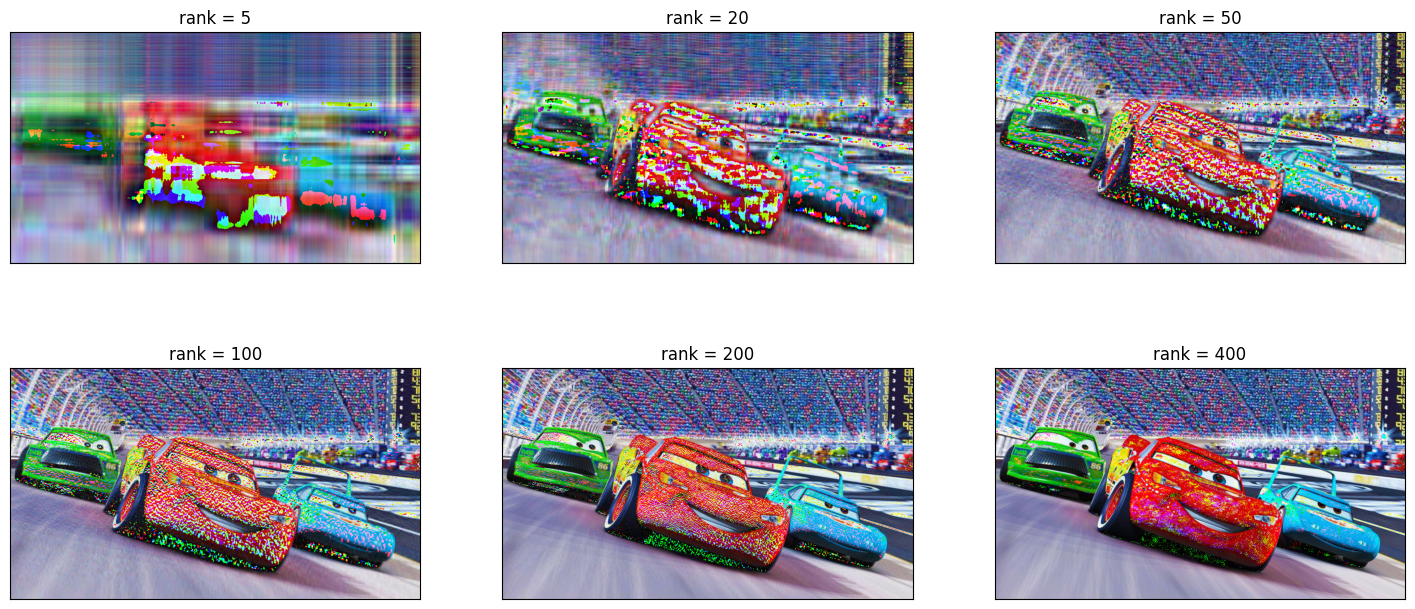

In [13]:
errors_block_power, mem_block_power, compression_time = show_compressed_images("block_power")
print(f"compression_time = {compression_time}")

Посмотрим, сколько памяти занима.т сжатые картинки отнсительно несжатой в зависимости от ранга.

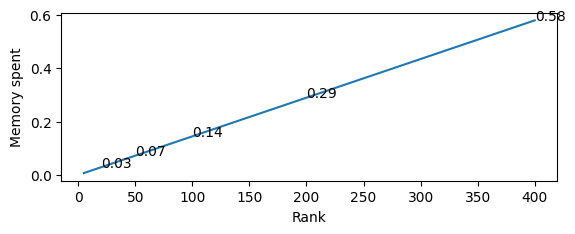

In [53]:
plt.figure()

plt.subplot(2,1,1)
plt.ylabel("Memory spent")
plt.xlabel("Rank")
plt.plot(ranks, mem_numpy)
for rank, mem in zip(ranks[1:], mem_numpy[1:]):
        plt.annotate(f"{mem:.2f}", [rank, mem])
plt.show()

Посмотрим на время сжатия и относительную среднюю квадратическую ошибку каждого метода

In [54]:
def plot_info(errors):
    plt.ylabel("Relative error")
    plt.xlabel("Rank")
    plt.plot(ranks, errors)
    plt.plot(ranks[-1], errors[-1], 'o')
    for rank, err in zip(ranks[1:], errors[1:]):
        plt.annotate(f"{err:.2f}", [rank, err])
    plt.show()

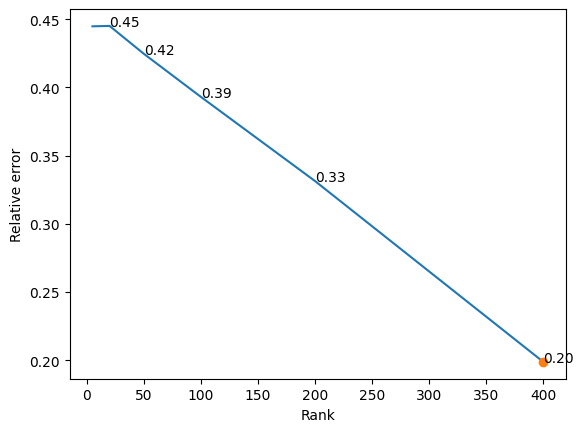

In [55]:
plot_info(errors_numpy)

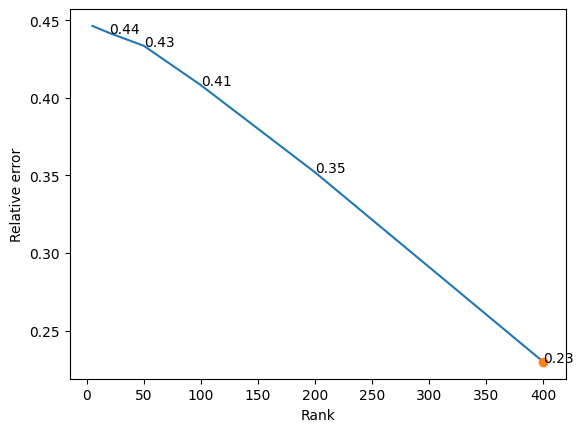

In [56]:
plot_info(errors_power_method)

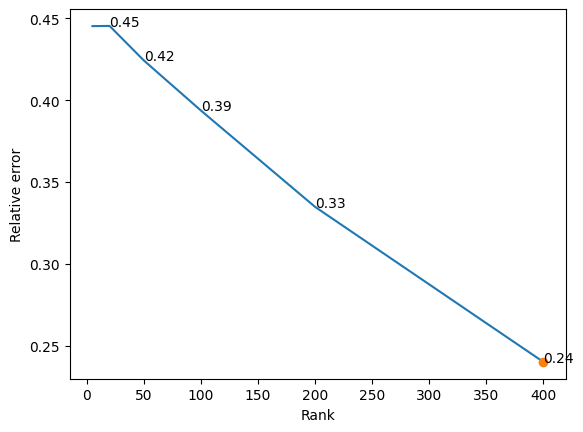

In [57]:
plot_info(errors_block_power)

Видно, что обычный степенной метод работате сильно дольше по сравнению с numpy и Block Power, но при этом все равно справляется хорошо сжать и показать достойную относительную ошибку 

Block Power метод оказался очень даже неплох и в целом лишь немногим хуже svd из numpy